# Monthly Performance Report — Aerobic Base Monitoring

## Context & Objective

### Purpose
this notebook used for monthly performance monitoring with strava running data focusing on : 

- Aerobic efficiency (MAF/Z2)
- HR stability & cardiac drift
- time to time adaptation.

why monthly? why not weekly? 

- weekly = too much noise (weather, fatigue, terrain)
- monthly = physiologiacl signal

## Definition & Assumptions. 

### Heart rate zones
- MAF HR MAX  = 154 bpm
= MAF TOLERANCE HR = 155-160 
- Zone 2 (Z2) = 139 - 160 (RHR method, resting heartrate 55 bpm, max heartrate 198 bpm).

### Run Classifications 
- MAF run = HR AVG =< MAF HR or tolerance HR
- LONGRUN = duration >= 60 min or longest run of the week by duration
- Recovery week = planned deload, every 4th week (volume cut by 20-30%)

## Data Loading

In [32]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("default")

runs = pd.read_csv("../data/processed/runs_labeledv2.csv", parse_dates=["Activity Date"])
runs.head()


,Activity ID,Activity Date,Activity Name,Activity Type,Activity Description,Elapsed Time,Distance,Max Heart Rate,Relative Effort,Commute,...,Competition,Long Run,For a Cause,With Kid,Downhill Distance,Media,pace_min_per_km,training_phase,maf_zone,maf_band
0,14608741405,2025-05-27 10:04:02,5k,Run,PERUT AING KERAMM AJGGG\ntumben bat larinya berat,2296,5.03,190.0,123.0,False,...,NaN,NaN,NaN,NaN,NaN,media/63c95eee-186a-4bec-a5bc-5575f5a297d6.jpg...,6.918500,pre_injury,non_maf,non_maf
1,14629243874,2025-05-29 09:56:36,3k,Run,"seminggu ga lari, berat bat jing",1356,3.11,187.0,74.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,7.050197,pre_injury,non_maf,non_maf
2,14661013167,2025-06-01 09:40:08,10K,Run,kasus men,5037,10.05,183.0,248.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,7.659314,pre_injury,non_maf,non_maf
3,14681393833,2025-06-03 09:58:41,5k,Run,lumayan iyah,2364,5.02,179.0,114.0,False,...,NaN,NaN,NaN,NaN,NaN,media/0f020806-b0b0-4d3a-a28e-f55787d4cd7c.jpg,7.659314,pre_injury,non_maf,non_maf
4,14702999166,2025-06-05 10:16:54,Tipis tipis,Run,MAF training,1974,3.20,157.0,32.0,False,...,NaN,NaN,NaN,NaN,NaN,NaN,9.162544,pre_injury,maf_pure,maf_clean


## Data Preps

In [33]:
runs["Activity Date"] = pd.to_datetime(runs["Activity Date"])
runs = runs.sort_values("Activity Date")

In [34]:
required_cols = ["Activity Date", "pace_min_per_km", "Average Heart Rate", "maf_band", "Moving Time"]
missing = [c for c in required_cols if c not in runs.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

## Monthly MAF pace trend

In [35]:
maf_clean = runs[runs["maf_band"] == "maf_clean"].copy()

In [36]:
monthly_maf = (
    maf_clean
    .set_index("Activity Date")
    .resample("M")["pace_min_per_km"]
    .agg(["median", "mean", "count"])
)



C:\Users\ANGELO\AppData\Local\Temp\ipykernel_12756\4072625322.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["pace_min_per_km"]


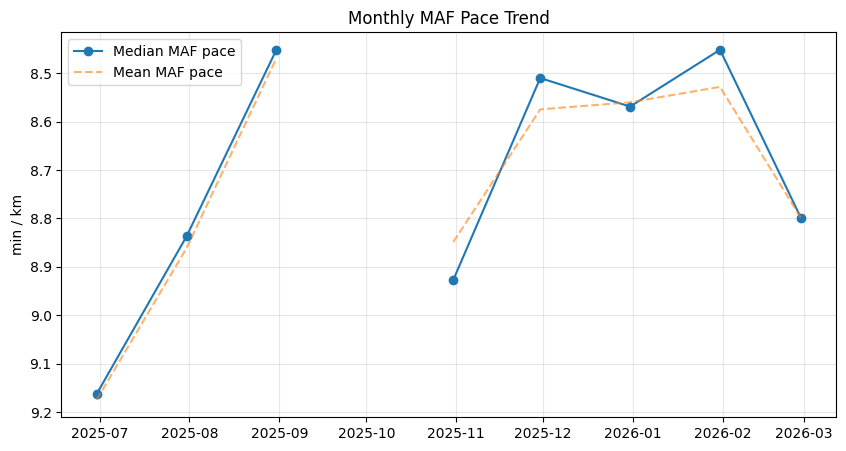

In [37]:
plt.figure(figsize=(10,5))
plt.plot(monthly_maf.index, monthly_maf["median"], marker="o", label="Median MAF pace")
plt.plot(monthly_maf.index, monthly_maf["mean"], linestyle="--", alpha=0.6, label="Mean MAF pace")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.title("Monthly MAF Pace Trend")
plt.ylabel("min / km")
plt.legend()
plt.show()

## Monthly HR stability Trend

In [38]:
monthly_hr_std = (
maf_clean
.set_index("Activity Date")
.resample("M")["Average Heart Rate"]
.std()
)

C:\Users\ANGELO\AppData\Local\Temp\ipykernel_12756\1420234600.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["Average Heart Rate"]


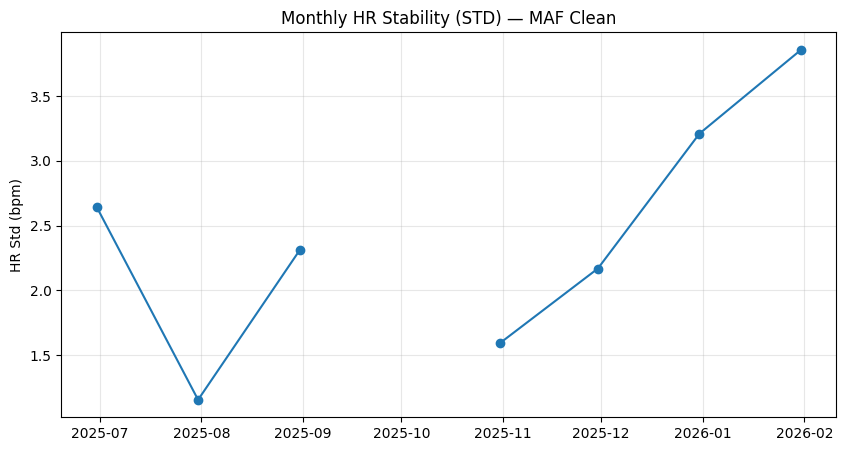

In [39]:
plt.figure(figsize=(10,5))
plt.plot(monthly_hr_std.index, monthly_hr_std.values, marker="o")
plt.grid(True, alpha=0.3)
plt.title("Monthly HR Stability (STD) — MAF Clean")
plt.ylabel("HR Std (bpm)")
plt.show()

## Longrun HR vs Duration

In [40]:
long_runs = (
runs
.sort_values("Moving Time", ascending=False)
.groupby(runs["Activity Date"].dt.to_period("M"))
.head(1)
.copy()
)


long_runs["duration_min"] = long_runs["Moving Time"] / 60


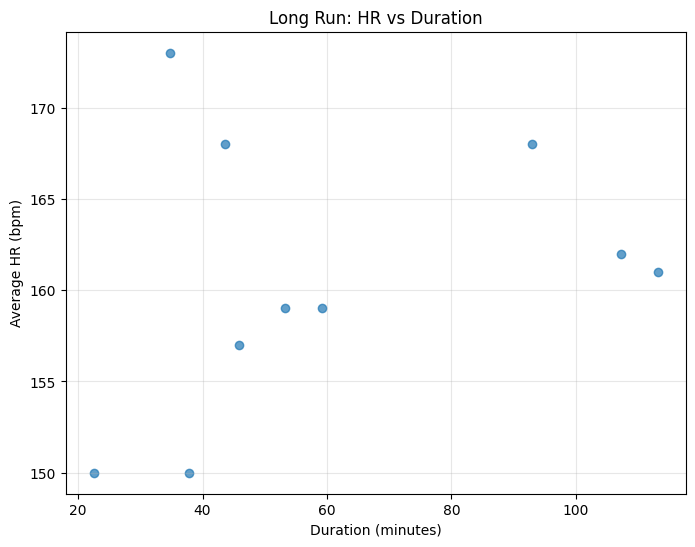

In [41]:
plt.figure(figsize=(8,6))
plt.scatter(long_runs["duration_min"], long_runs["Average Heart Rate"], alpha=0.7)
plt.grid(True, alpha=0.3)
plt.title("Long Run: HR vs Duration")
plt.xlabel("Duration (minutes)")
plt.ylabel("Average HR (bpm)")
plt.show()

## Pace vs HR (efficiency map)

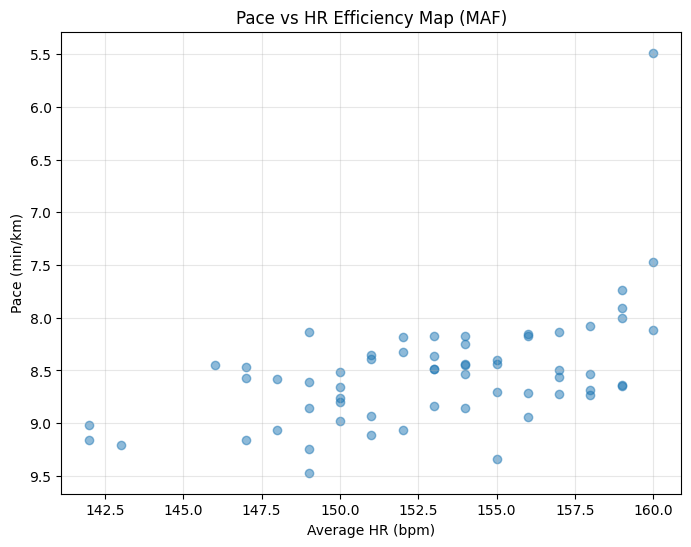

In [42]:
maf_all = runs[runs["maf_band"].isin(["maf_clean", "maf_tolerated"])].copy()


plt.figure(figsize=(8,6))
plt.scatter(maf_all["Average Heart Rate"], maf_all["pace_min_per_km"], alpha=0.5)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.title("Pace vs HR Efficiency Map (MAF)")
plt.xlabel("Average HR (bpm)")
plt.ylabel("Pace (min/km)")
plt.show()

## Executive Monthly Sumary Table


In [43]:
summary = pd.DataFrame({
"median_maf_pace": monthly_maf["median"],
"mean_maf_pace": monthly_maf["mean"],
"maf_hr_std": monthly_hr_std,
"maf_run_count": monthly_maf["count"],
})
summary

,median_maf_pace,mean_maf_pace,maf_hr_std,maf_run_count
Activity Date,,,,
2025-06-30,9.162544,9.174357,2.645751,3
2025-07-31,8.837045,8.861374,1.154701,3
2025-08-31,8.451657,8.468946,2.309401,3
2025-09-30,NaN,NaN,NaN,0
2025-10-31,8.926977,8.848587,1.589899,9
2025-11-30,8.509981,8.574691,2.167948,6
2025-12-31,8.568980,8.560028,3.209361,5
2026-01-31,8.451657,8.528250,3.856518,11
2026-02-28,8.799718,8.799718,NaN,1
